In [1]:
%load_ext autoreload
%autoreload 2
import sys
import torch 
import itertools
import numpy as np
import seaborn as sns
import pandas as pd
sns.set_style('white')

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
sys.path.insert(0, '../MIMIC_notebooks')
sys.path.insert(0, '../WILDS_notebooks')

import matplotlib.pyplot as plt
from scipy.sparse import load_npz
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.calibration import calibration_curve

# from baselines import cdmm
from sarpu.pu_learning import *
from sarpu.PUmodels import LogisticRegressionPU
from km.Kernel_MPE_grad_threshold import wrapper as ramaswamy
from sklearn.metrics import roc_auc_score, average_precision_score
from paths import FIG_DIR, RESULTS_DIR

from gpu_utils import restrict_GPU_pytorch
from simulation_helpers import generate_s_scar
from method import train_relative_estimator, get_loss, get_model_fname, load_model
from eval_fs import eval_relative_prior, eval_pred_prior, eval_PURPLE_relative_priors
from cmod_helper_fs import preprocess_cmod_data, MODE_GROUP_MAP, normalize_x, MODE_GROUP_MAP_WITH_OTHER
from cmod_helper_fs import get_group_weights, prettify_category_name, prettify_group_name
restrict_GPU_pytorch('0')

Using GPU:0


## Compare constrained and unconstrained model

In [3]:
dfs = []

method = 'ours'
val_loss_key = 'auprc'
categories = ['gender', 'identity', 'religion', 'sexual_orientation']
for i, category in enumerate(categories):
    df = pd.read_csv(RESULTS_DIR + "real_cmod_" + method + "_" + category + "_results" + "stratified_by_none")
    df['estimator_type'] = 'PURPLE'
    dfs.append(df)
purple_df = pd.concat(dfs)
purple_df = purple_df.sort_values([val_loss_key], ascending=False).groupby(['category', 'seed']).head(1)
purple_df = purple_df.reset_index()

pytorch_uc_df = pd.read_csv(RESULTS_DIR + 'unconstrained_model_cmod' )
pytorch_uc_df['estimator_type'] = 'Unconstrained' 
# uc_df['estimator_type'] = 'unconstrained'
all_results_df = pd.concat([pytorch_uc_df, purple_df])

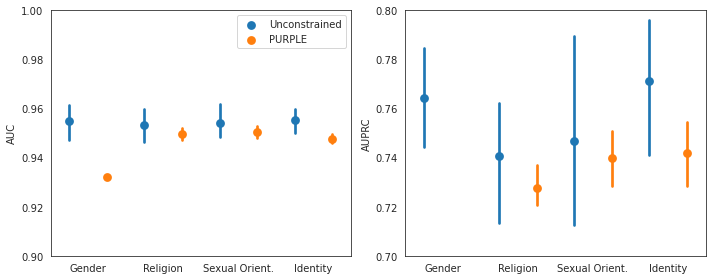

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
for i, val_loss_key in enumerate(['auc', 'auprc']):
    ax = axs[i]
    all_results_df['pretty_category'] = all_results_df['category'].apply(lambda x : prettify_category_name[x])
    sns.pointplot(x='pretty_category', hue='estimator_type', y=val_loss_key, dodge=.5, join=False, 
                  data=all_results_df, ax=ax)
    if i != 0:
        ax.legend().remove()
        ax.set_ylim(.7, .8)
        ax.set_ylabel("AUPRC")
    else:
        ax.set_ylim(.9, 1)
        ax.set_ylabel("AUC")
        ax.legend_.set_title(None)

#         ax.legend().texts[0].set_text("")
#         handles, labels = ax.get_legend_handles_labels()
#         ax.legend(handles=handles[1:], labels=labels[1:])
    ax.set_xlabel("")
    
plt.tight_layout()
plt.savefig(FIG_DIR + "/cmod_auprc_auc_checks.pdf", dpi=300)

## Generate table of AUCs and AUPRCs

In [4]:
# Unconstrained
df = pd.read_csv(RESULTS_DIR + 'unconstrained_model_cmod' )
mean_df = df.groupby('category').mean().reset_index()[['category', 'auc', 'auprc']]
std_df = df.groupby('category').std().reset_index()[['category', 'auc', 'auprc']]

mean_df.rename(columns={'auc': 'auc_mean', 'auprc': 'auprc_mean'}, inplace=True)
std_df.rename(columns={'auc': 'auc_std', 'auprc': 'auprc_std'}, inplace=True)

def combine_columns(auc_mean, auc_std):
    return "$" + '{0:.3f}'.format(auc_mean) + ' ± ' + '{0:.3f}'.format(auc_std) + "$"

def combine_mean_std_df(mean_df, std_df):
    df = pd.merge(mean_df, std_df, left_on='category', right_on='category')
    df['auc'] = df.apply(lambda row: combine_columns(row['auc_mean'], row['auc_std']), axis=1)
    df['auprc'] = df.apply(lambda row: combine_columns(row['auprc_mean'], row['auprc_std']), axis=1)
    return df
uc_df = combine_mean_std_df(mean_df, std_df)
uc_df.index = uc_df.category
uc_df.rename(columns={'auc': 'Unconstrained (AUC)', 
                   'auprc': 'Unconstrained (AUPRC)'}, inplace=True)
uc_df = uc_df[['Unconstrained (AUC)', 'Unconstrained (AUPRC)']].T.reset_index()

In [24]:
# Constrained
# Load the auc and auprc 
categories = ['gender', 'identity', 'religion', 'sexual_orientation']
val_loss_key = 'auprc'
dfs = []
for i, category in enumerate(categories):
    method = 'ours'
    df = pd.read_csv(RESULTS_DIR + "real_cmod_" + method + "_" + category + "_results" + "stratified_by_none")
#     df = df.sort_values([val_loss_key], ascending=False).groupby(['group', 'seed']).head(1)
    df = df.groupby('seed').first().reset_index()
    dfs.append(df)
df = pd.concat(dfs)
# df = df.sort_values([val_loss_key], ascending=False).groupby(['category', 'group', 'seed']).head(1).reset_index()
print(len(df))
mean_df = df.groupby('category').mean().reset_index()[['category', 'auc', 'auprc']]
std_df = df.groupby('category').std().reset_index()[['category', 'auc', 'auprc']]

mean_df.rename(columns={'auc': 'auc_mean', 'auprc': 'auprc_mean'}, inplace=True)
std_df.rename(columns={'auc': 'auc_std', 'auprc': 'auprc_std'}, inplace=True)

purple_df = combine_mean_std_df(mean_df, std_df)
purple_df.index = purple_df.category
purple_df.rename(columns={'auc': '\texttt{PURPLE} (AUC)', 
                   'auprc': '\texttt{PURPLE} (AUPRC)'}, inplace=True)
purple_df = purple_df[['\texttt{PURPLE} (AUC)', '\texttt{PURPLE} (AUPRC)']].T.reset_index()


16


In [115]:
table_df = pd.concat([purple_df, uc_df], ignore_index=True, axis=0)
table_df.rename(columns={"gender":"Gender", 
                   "identity":"Ethnicity",
                   "religion": "Religion",
                   "sexual_orientation": "Sexual Orientation"
                  }, inplace=True)
latex_str = table_df.to_latex(escape=False, column_format="r|llll", index=False)
latex_str = latex_str.replace("±", "\pm")
print(latex_str)

\begin{tabular}{r|llll}
\toprule
                   index &           Gender &        Ethnicity &         Religion & Sexual Orientation \\
\midrule
   \texttt{PURPLE} (AUC) &  $0.948 \pm 0.004$ &  $0.948 \pm 0.002$ &  $0.950 \pm 0.003$ &    $0.950 \pm 0.003$ \\
 \texttt{PURPLE} (AUPRC) &  $0.738 \pm 0.022$ &  $0.742 \pm 0.017$ &  $0.728 \pm 0.010$ &    $0.740 \pm 0.014$ \\
     Unconstrained (AUC) &  $0.955 \pm 0.009$ &  $0.956 \pm 0.006$ &  $0.953 \pm 0.008$ &    $0.954 \pm 0.009$ \\
   Unconstrained (AUPRC) &  $0.764 \pm 0.026$ &  $0.771 \pm 0.034$ &  $0.741 \pm 0.034$ &    $0.747 \pm 0.048$ \\
\bottomrule
\end{tabular}



## T-Test for Significant Differences in AUC and AUPRC

In [116]:
from scipy.stats import ttest_ind
ttest_df = pd.merge(pd.read_csv(RESULTS_DIR + 'unconstrained_model_cmod' ), df, left_on=['category', 'seed'], right_on=['category', 'seed'])

for category in set(ttest_df['category']):
    category_ttest_df = ttest_df[ttest_df['category'] == category]
    print(category)
    print(ttest_ind(category_ttest_df['auprc_x'], category_ttest_df['auprc_y']))
    print(ttest_ind(category_ttest_df['auc_x'], category_ttest_df['auc_y']))
# AUCs are not significantly different in any category, AUPRC is significantly different for gender?

sexual_orientation
Ttest_indResult(statistic=0.3200267817072316, pvalue=0.757146417979713)
Ttest_indResult(statistic=0.8983417333989988, pvalue=0.39523577903144413)
identity
Ttest_indResult(statistic=1.7127739685173127, pvalue=0.12510880578100966)
Ttest_indResult(statistic=2.7052784213870504, pvalue=0.026853662250450282)
religion
Ttest_indResult(statistic=0.8083281036005178, pvalue=0.4422735866260583)
Ttest_indResult(statistic=0.9068545790880528, pvalue=0.3909802598337063)
gender
Ttest_indResult(statistic=1.7519937469128752, pvalue=0.11787467036750593)
Ttest_indResult(statistic=1.492262662854826, pvalue=0.17397505507737573)


## Group-specific calibration plots

In [65]:
include_complement = True
thresh = .5
split_dir = "../../data/real_true_labels/content_mod/" + str(thresh) + "/"
categories = MODE_GROUP_MAP_WITH_OTHER.keys()

    
# read features and labels
x = np.load(split_dir + 'vals.npz.npy')
s = np.load(split_dir + 'observed_labels.npy')
text = np.load(split_dir + 'text.npy')
toxicity = np.load(split_dir + 'toxicity.npy')

# meta experiment config
n_runs = 5
n_attributes = x.shape[1]

n_groups = len(groups)

penalty = 'l1'
solver = 'liblinear'
fit_intercept = True
scar_assumption = True
classification_model_type = LogisticRegressionPU
classification_attributes = np.array(list(range(n_attributes))) + n_groups
stratify_mode = 'none'
seeds = [10, 52, 30, 42, 1000]
lamda_opts = [0, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
lamda_opts = [1e-4]
norm_flag = 'unnorm'
categories = ['identity', 'sexual_orientation','religion', 'gender']
### Enumerate experiment configurations
expmt_configs = []
for category in categories:
    groups = MODE_GROUP_MAP_WITH_OTHER[category]
    for i in range(n_runs):


        # there is a best lamda_opt for each (category, i) pair. 
        for lamda in lamda_opts:
            
            expmt_config = {'scar_assumption': scar_assumption, 
                'lamda': lamda, 'n_groups': len(groups),
                'n_attributes': n_attributes,'groups': groups,
                'labeling_frequencies': (None, None),
                'category': category, 'n_epochs': 10000,
                'optimizer': 'Adam', 
                'seed': seeds[i], 
                'estimator_type': 'logreg', 'n_batches': 5,
                'mode': 'unnorm', 'stratify_mode': stratify_mode}
            expmt_configs.append(expmt_config)

In [66]:
results = []

for expmt_config in tqdm(expmt_configs):
    groups = expmt_config['groups']
    seed = expmt_config['seed']
    category = expmt_config['category']
    n_groups = expmt_config['n_groups']
    train, val, test = preprocess_cmod_data(x, y=[], s=s, text=text, toxicity=toxicity,
                                            groups=groups, 
                                            expmt_config=expmt_config, random_seed=seed)
    # Output is processed x, s, and y and group_idxs 
    x_train, y_train, s_train, t_train, tox_train = train
    x_val, y_val, s_val, t_val, tox_val = val
    x_test, y_test, s_test, t_test, tox_test = test

    x_train_norm, x_val_norm, x_test_norm = normalize_x(x_train, x_val, x_test, 
                                                        n_groups=n_groups)
    if expmt_config['mode'] != 'norm':
        train_data =  x_train
        val_data = x_val
        test_data = x_test
    else:
        train_data = x_train_norm
        val_data = x_val_norm
        test_data = x_test_norm
        
    expmt_config['group_weights'] = get_group_weights(x_train, n_groups)

    model_fname = get_model_fname(expmt_config)
    print(model_fname)
    model_fname = model_fname + 'model_final_10000'
    f_model = load_model(model_fname, expmt_config)
    
    f_model.cuda()
    s_test_preds = f_model(torch.Tensor(test_data).cuda()).detach().cpu().numpy().flatten()

    for j, group in enumerate(groups):
        group_idxs = np.squeeze(np.where(test_data[:,j] == 1)[0])
        n_bins = 10
        cal_y_1, cal_x_1 = calibration_curve(s_test[group_idxs], s_test_preds[group_idxs], n_bins=n_bins, strategy='quantile')
        results.extend([{'x': x_val, 'y': y_val, 
                         'seed': seed, 'mode': category,
                         'group': group, 'decile': i,
                         'n_group_examples': len(group_idxs)} for i,(x_val, y_val) in enumerate(zip(cal_x_1, cal_y_1))])

  0%|          | 0/20 [00:00<?, ?it/s]

black 4872
white 7969
asian 1518
latino 693
other 79863
# of Comments:  133782
# of Comments in 1 Group:  90110 

b9341fa2b2826c01e01f5b354b9e1854
black 4872
white 7969
asian 1518
latino 693
other 79863
# of Comments:  133782
# of Comments in 1 Group:  90110 

56c24a931de500414c4b7cbf5eaa20ae
black 4872
white 7969
asian 1518
latino 693
other 79863
# of Comments:  133782
# of Comments in 1 Group:  90110 

5d1b404b24d511b146c59177c3cf6e84
black 4872
white 7969
asian 1518
latino 693
other 79863
# of Comments:  133782
# of Comments in 1 Group:  90110 

6685fe71cbf1c5a043646d911ff91652
black 4872
white 7969
asian 1518
latino 693
other 79863
# of Comments:  133782
# of Comments in 1 Group:  90110 

6495503c4a99e0439770def317f5bc01
heterosexual 469
homosexual_gay_or_lesbian 3810
other 79863
# of Comments:  133782
# of Comments in 1 Group:  83558 

dc911aa54222ead1b4e4fa77a8aa0b32
heterosexual 469
homosexual_gay_or_lesbian 3810
other 79863
# of Comments:  133782
# of Comments in 1 Group:  8355

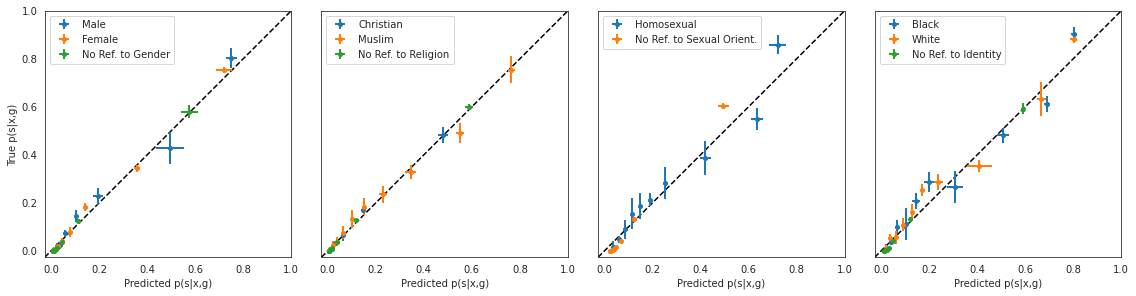

In [74]:
results_df = pd.DataFrame(results)
results_df.to_csv(RESULTS_DIR + "cmod_calibration_over_splits")
results_df = results_df[results_df['n_group_examples'] > 500]
# results_df['group']  = results_df['group'].apply(lambda x: prettify_group_name[x])
fig, axs = plt.subplots(1, 4, figsize=(16, 4), sharey=True)
categories = MODE_GROUP_MAP_WITH_OTHER.keys()

def map_no_reference_to_no_ref_to_group(x, category):
    if x == 'No reference':
        return x + " to " + prettify_category_name(category)
    return x
for i, mode in enumerate(categories):
    groups = MODE_GROUP_MAP_WITH_OTHER[mode]
    ax = axs[i]
    plt.sca(ax)
    mode_results_df = results_df[results_df['mode'] == mode]
    for group in groups:
        group_results_df = mode_results_df[mode_results_df['group'] == group]
        if group == 'other':
            pretty_group_name = 'No Ref. to ' + prettify_category_name[mode]
        else:
            pretty_group_name = prettify_group_name[group]
        if len(group_results_df):
            x_y_means = group_results_df.groupby(['decile']).mean().reset_index()[['x', 'y']]
            x_y_std_errs = group_results_df.groupby(['decile']).std().reset_index()[['x', 'y']]
            plt.errorbar(x_y_means['x'], x_y_means['y'], xerr=x_y_std_errs['x'], yerr=x_y_std_errs['y'], capsize=0, ls='none', 
                        elinewidth=2, label=pretty_group_name, fmt='o', ms=4)

            
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()
    min_val, max_val = min(xmin, ymin), max(ymax, xmax)
    min_val, max_val = -0.026509457584140198, 1
    
    ax.set_ylim(min_val, max_val)
    ax.set_xlim(min_val, max_val)
    ax.plot([min_val, max_val], [min_val, max_val], c='black', ls='--', zorder=-1)
    ax.set_xlabel("Predicted p(s|x,g)")
    if  i == 0:
        ax.set_ylabel("True p(s|x,g)")
    ax.legend(loc='upper left')
    ax.set_aspect('equal')

plt.tight_layout()
plt.savefig(FIG_DIR + "cmod_calibration_plots.pdf", dpi=300)